Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-562e308952ca>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_df['Date'] = pd.to_datetime(traffic_df['Date'], errors='coerce')


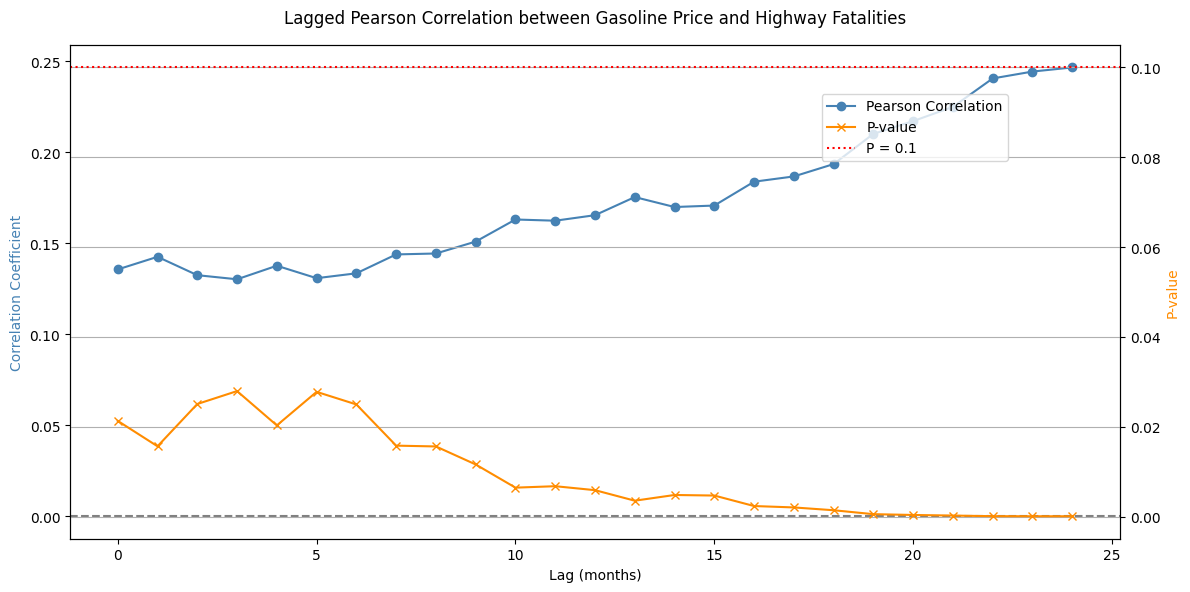

In [7]:
# ========== Step 0: Mount Google Drive ==========
from google.colab import drive
drive.mount('/content/drive')

# ========== Step 1: Import Packages ==========
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ========== Step 2: Load and Preprocess ==========
gasoline_path = '/content/drive/MyDrive/datathon 2025/weekly_gasoline_prices.csv'
traffic_path = '/content/drive/MyDrive/datathon 2025/monthly_transportation_statistics.csv'

gasoline_df = pd.read_csv(gasoline_path)
traffic_df = pd.read_csv(traffic_path)

gasoline_df['Date'] = pd.to_datetime(gasoline_df['Date'], errors='coerce')
traffic_df['Date'] = pd.to_datetime(traffic_df['Date'], errors='coerce')

# ========== Step 3: Aggregate to Monthly ==========
gasoline_df['Month'] = gasoline_df['Date'].dt.to_period('M')
monthly_gas = gasoline_df.groupby('Month')['Price'].mean().reset_index()
monthly_gas['Month'] = monthly_gas['Month'].dt.to_timestamp()

traffic_df['Month'] = traffic_df['Date'].dt.to_period('M')
monthly_crash = traffic_df.groupby('Month')['Highway Fatalities'].sum().reset_index()
monthly_crash['Month'] = monthly_crash['Month'].dt.to_timestamp()

# ========== Step 4: Merge Data ==========
merged_df = pd.merge(monthly_crash, monthly_gas, on='Month', how='inner')
merged_df = merged_df.rename(columns={'Month': 'Date', 'Highway Fatalities': 'Crashes'})

# ========== Step 5: Generate Lagged Price Variables ==========
for lag in range(25):
    merged_df[f'Price_Lag_{lag}'] = merged_df['Price'].shift(lag)

# ========== Step 6: Compute Pearson Correlations ==========
lags = list(range(25))
correlations = []
p_values = []

for lag in lags:
    valid_data = merged_df[['Crashes', f'Price_Lag_{lag}']].dropna()
    corr, pval = pearsonr(valid_data['Crashes'], valid_data[f'Price_Lag_{lag}'])
    correlations.append(corr)
    p_values.append(pval)

# ========== Step 7: Plot ==========
fig, ax1 = plt.subplots(figsize=(12, 6))

# Pearson correlation (left y-axis)
ax1.plot(lags, correlations, marker='o', color='steelblue', label='Pearson Correlation')
ax1.set_xlabel('Lag (months)')
ax1.set_ylabel('Correlation Coefficient', color='steelblue')
ax1.axhline(0, linestyle='--', color='grey')

# P-values (right y-axis)
ax2 = ax1.twinx()
ax2.plot(lags, p_values, marker='x', color='darkorange', label='P-value')
ax2.set_ylabel('P-value', color='darkorange')
ax2.axhline(0.1, linestyle=':', color='red', label='P = 0.1')

fig.suptitle('Lagged Pearson Correlation between Gasoline Price and Highway Fatalities')
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.grid(True)
plt.tight_layout()
plt.show()
